In [19]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[list,add_messages]

search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return END

tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent",agent)
subgraph.add_node("tool_node",tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent",tools_router)
subgraph.add_edge("tool_node","agent")

search_app = subgraph.compile()



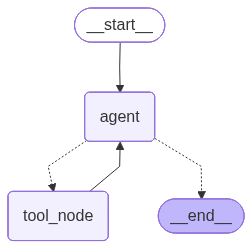

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [21]:
response = search_app.invoke({"messages":[HumanMessage(content="How is the weather in colombo")]})
response

{'messages': [HumanMessage(content='How is the weather in colombo', additional_kwargs={}, response_metadata={}, id='a60774a1-0a97-470b-8595-7617ae0778ac'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'b4a1s9t2v', 'function': {'arguments': '{"query":"colombo weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.036804942, 'prompt_time': 0.019329716, 'queue_time': 0.054963204, 'total_time': 0.056134658}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bcd5b3d1-1e57-4b3d-b3da-f898cb2cad6b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'colombo weather'}, 'id': 'b4a1s9t2v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}),
  ToolMessage(content='[{"url": "https://

### Case 1 : Shared schema (Direct embedding)

In [22]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_core.messages import HumanMessage

# Define parent graph with sam schema
class ParentsState(TypedDict):
    messages: Annotated[list,add_messages]

#Create parent graph

parent_graph = StateGraph(ParentsState)

# Add the sub graph as node
parent_graph.add_node("search_agent",search_app)

# Connect the flow
parent_graph.add_edge(START,"search_agent")
parent_graph.add_edge("search_agent",END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke(
    {"messages": [HumanMessage(content="How is the weather in colombo")]},
    config={"configurable": {"thread_id": "weather-thread-1"}},
)

last_msg = result["messages"][-1]
print(last_msg.type, ":", last_msg.content)








ai : The weather in Colombo in December 2025 is expected to be partly cloudy with an average temperature of 29°C (84°F) during the day and 24°C (75°F) at night. There may be some rain on around 8-15 days of the month, with an average of 159 mm (6.3 in) of rainfall. It is recommended to bring an umbrella and rubber boots to stay dry. The humidity comfort level is expected to be around 80-90% throughout the month.


### case 2 : Different Schema (Invoke with Transformation)

In [28]:
from typing import TypedDict,Annotated, Dict
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query:str
    response:str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }

    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)

    # transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraphs
parent_graph.add_node("search_agent",search_agent)

# Connect the flow
parent_graph.add_edge(START,"search_agent")
parent_graph.add_edge("search_agent",END)

parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke(
    {"query": "How is the weather in colombo","response":""},
    config={"configurable": {"thread_id": "weather-thread-2"}},
)


print("Response:", result["response"])


Response: The weather in Colombo in December 2025 is expected to be mostly rainy with temperatures ranging from 25°C to 30°C. There will be around 8-15 days of rain throughout the month, with an average of 159 mm of precipitation. The humidity comfort level will be mostly uncomfortable and miserable, with an average relative humidity of 84%. It is recommended to bring rubber boots and an umbrella to stay dry.
